In [33]:
# all imports
from my_objects import *
from my_objects import ModuleProperties, CombiningModules

In [34]:
def looping_function(num_modules, num_internal_species, num_pins, stoich_matrix):
    
    species_names = []

    for i in range(num_internal_species):
        species_names.append(i+1+num_pins)

    for i in range(num_pins):
        species_names.append(i+1)

    for i in range(stoich_matrix.shape[1]-num_internal_species-num_pins*2):
        species_names.append(i+1+num_internal_species)

    for i in range(num_pins):
        species_names.append(i+num_internal_species+num_pins+1+(stoich_matrix.shape[1]-num_internal_species-num_pins*2))

    species_grid = [list(species_names)]
    for i in range(num_modules-1):
        prev = species_grid[-1]
        new_species_names = []

        for j in range(num_internal_species):
            new_species_names.append(prev[-1] + 1 + j)

        for j in range(num_pins):
            new_species_names.append(prev[-1] + j)

        for j in range(stoich_matrix.shape[1]-num_internal_species-num_pins*2):
            new_species_names.append(prev[-1] + 1 + j + num_internal_species)

        for j in range(num_pins):
            new_species_names.append(prev[-1] + j + num_internal_species + num_pins + (stoich_matrix.shape[1]-num_internal_species-num_pins*2))

        species_grid.append(new_species_names)


    def num_to_code(n):
        n -= 1
        letters = []
        for _ in range(3):
            letters.append(chr(ord('A') + (n % 26)))
            n //= 26
        return ''.join(reversed(letters))

    def convert_2d_array_to_codes(int_grid):
        return [
            [num_to_code(x) for x in row]
            for row in int_grid
        ]

    species_string_grid = convert_2d_array_to_codes(species_grid)

    mod_list = []
    for i in range(num_modules):
        mod_i = ModuleProperties(stoich_matrix, num_internal_species, species_string_grid[i])
        mod_list.append(mod_i)
        
    mod_combined = mod_list[0]
    
    import time
    import statistics

    def time_stats(func, n=10, *args, **kwargs):
        times = []
        for _ in range(n):
            start = time.perf_counter()
            func(*args, **kwargs)
            times.append(time.perf_counter() - start)
        return statistics.mean(times), statistics.stdev(times)

    def combining_all_modules(mod_list, num_modules, mod_combined):
        for i in range(1, num_modules):
            mod_combined = CombiningModules(mod_combined, mod_list[i])
            resis_matrix = mod_combined.calculate_fundamental_resistance_matrix()
        return mod_combined, resis_matrix
    

    mod_combined_properties = combining_all_modules(mod_list, num_modules, mod_combined)[0].module_properties()


    def calculating_reistance_matrix_without_modularity():
        return mod_combined_properties.calculate_fundamental_resistance_matrix()

    modular_mean_combine, modular_std_combine = time_stats(
    lambda: combining_all_modules(mod_list, num_modules, mod_combined), n=2)

    unmodular_mean_combine, unmodular_std_combine = time_stats(
    lambda: calculating_reistance_matrix_without_modularity(), n=2)

    print(f"Modular combining: {modular_mean_combine:.6f} seconds (std: {modular_std_combine:.6f})")
    print(f"Unmodular combining: {unmodular_mean_combine:.6f} seconds (std: {unmodular_std_combine:.6f})")

    return modular_mean_combine, modular_std_combine, unmodular_mean_combine, unmodular_std_combine
    


In [35]:
num_modules = 2
stoich_matrix = Matrix( [[-1,0,-1,-1,0],
                   [1,-1,0,0,0],
                   [0,1,1,0,-1],
                   [0,0,0,1,0],
                   [0,0,0,0,1]] )
num_internal_species = 3
num_pins = 1

looping_function(num_modules, num_internal_species, num_pins, stoich_matrix)

Modular combining: 0.087948 seconds (std: 0.010624)
Unmodular combining: 0.047405 seconds (std: 0.002252)


Modular combining: 0.125442 seconds (std: 0.020609)
Unmodular combining: 0.046939 seconds (std: 0.011684)
Modular combining: 0.685584 seconds (std: 0.018340)
Unmodular combining: 0.219410 seconds (std: 0.034856)


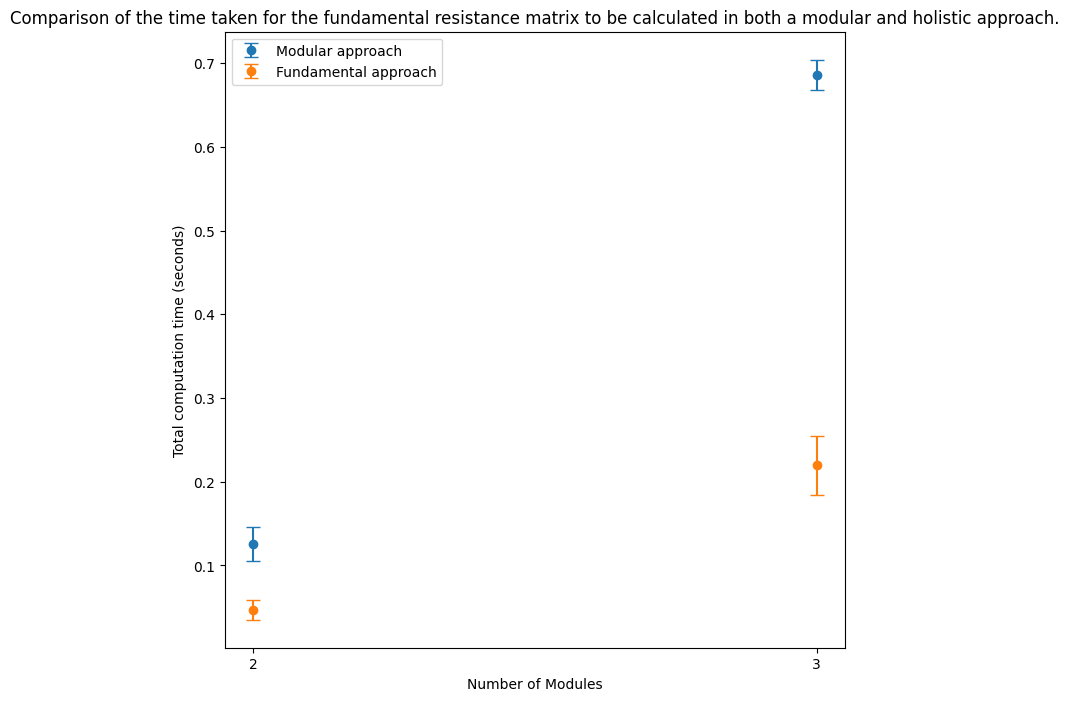

In [36]:
modular_mean_times = []
unmodular_mean_times = []
modular_std_times = []
unmodular_std_times = []

list_of_i = []
for i in range(4):
    if i<2:
        continue
    list_of_i.append(i)
    modular_mean_time, modular_std_time, unmodular_mean_time, unmodular_std_time = looping_function(i, num_internal_species, num_pins, stoich_matrix)
    modular_mean_times.append(modular_mean_time)
    unmodular_mean_times.append(unmodular_mean_time)
    modular_std_times.append(modular_std_time)
    unmodular_std_times.append(unmodular_std_time)
import matplotlib.pyplot as plt

plt.errorbar(list_of_i, modular_mean_times, yerr=modular_std_times, fmt='o', capsize=5, label="Modular approach")
plt.errorbar(list_of_i, unmodular_mean_times, yerr=unmodular_std_times, fmt='o', capsize=5, label = "Fundamental approach")
plt.xticks(list_of_i)

plt.xlabel("Number of Modules")
plt.ylabel("Total computation time (seconds)")
plt.title("Comparison of the time taken for the fundamental resistance matrix to be calculated in both a modular and holistic approach.")
plt.legend()
plt.show()